## ABSTRACT
This dataset represent the heartbeat signals derived from the the MIT-BIH Arrhythmia Dataset.

The signals correspond to electrocardiogram (ECG) shapes of heartbeats for:
* the normal case 
* cases affected by different arrhythmias and myocardial infarction

These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.

## Exploratory Analysis

Because this dataset is composed of time series, it is possible that the length of each series differs from the others.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from configparser import ConfigParser
from tqdm import tqdm
import seaborn as sn
import matplotlib.pyplot as plt                             # plotting
import numpy as np                                          # linear algebra
import os                                                   # accessing directory structure
import sys
import random
from multiprocessing import Pool
from functools import partial

import pandas as pd                                         # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import cdist
import pickle                                               # saving and loading compress files

import torch                                                # package for defining a model
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import gudhi as gd
from gudhi import RipsComplex, EuclideanWitnessComplex, EuclideanStrongWitnessComplex, WitnessComplex
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.homology import VietorisRipsPersistence

import numpy as np
from mpl_toolkits import mplot3d

In [2]:
config_path = "/home/andrea/Scrivania/Università/GTDA/exam/config.ini"
config = ConfigParser()
config.read(config_path)

dataset = {}
for key in ['train','validation', 'test']:
    dataset[key] = pd.read_csv(os.path.join(config['paths']['dataset'],f"dataset_{key}.csv"), header=None)
    nRow, nCol = dataset[key].shape
    print(f'There are {nRow} rows and {nCol} columns for the {key} dataset')

There are 76610 rows and 188 columns for the train dataset
There are 10944 rows and 188 columns for the validation dataset
There are 21892 rows and 188 columns for the test dataset


## MIT-BIH dataset
The MIT-BIH dataset consists of ECG recordings from 47 different subjects recorded at the sampling rate of 360Hz.

Each beat is annotated by at least two cardiologists and the annotations that has been used for this dataset to follow the accordance with Association for the Advancement of Medical Instrumentation (AAMI) EC57 standard:


| Category          	| Annotation 				|
| :----------------	| :------ 				|
| **N** (0)            	| Normal				|
|                   	| Left/Right bundle branch block	|
|                   	| Atrial escape				|
|                   	| Nodal escape				|
| **S** (1)            	| Atrial premature		 	|
|		    	| Aberrant atrial premature		|
|			| Nodal premature			|
|			| Supra-ventricular premature		|
| **V**	(2) 		| Premature ventricular contraction	|
|			| Ventricular escape			|
| **F** (3)		| Fusion of ventricular and normal	|
| **Q** (4)		| Paced					|
|			| Fusion of paced and normal		|
|			| Unclassifiable			|

## Preprocessing
As ECG beats are inputs of the proposed method we suggest
a simple and yet effective method for preprocessing ECG signals and extracting beats. The steps used for extracting beats
from an ECG signal are as follows:
1. Splitting the continuous ECG signal to 10s windows and select a 10s window from an ECG signal.
2. Normalizing the amplitude values to the range of between zero and one.
3. Finding the set of all local maximums based on zero crossings of the first derivative.
4. Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums.
5. Finding the median of R-R time intervals as the nominal heartbeat period of that window (T ).
6. For each R-peak, selecting a signal part with the length equal to 1.2T .
7. Padding each selected part with zeros to make its length equal to a predefined fixed length.

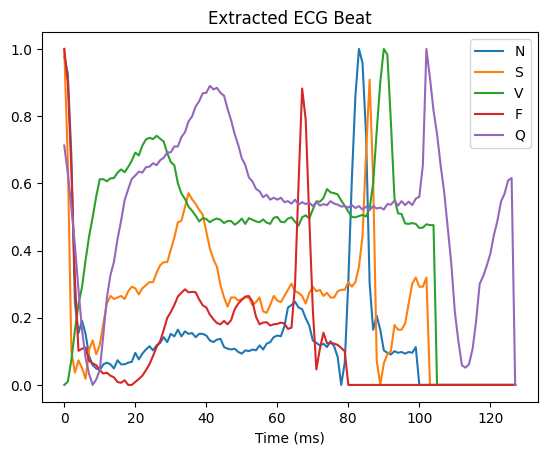

In [3]:
labels = {
    0:"N",
    1:"S",
    2:"V",
    3:"F",
    4:"Q"
}
for label in labels.keys():
    tmp = dataset['train'][dataset['train'][187] == label ].values[0][:-60]
    plt.plot(tmp, label = labels[label])

plt.legend()
plt.xlabel("Time (ms)")
plt.title("Extracted ECG Beat")
plt.show()

## DATA PRE-PROCESSING (Embedding)

Consider the full normalised time series (TS). As it was shown before it is possible to embedd in $\mathbb{R}^3$ as
$$
\left\{(y(t),y(t-\tau),y(t-2\tau))|t\in (2\tau, 1),\tau \in (0,0.5)\right\}
$$
this is thanks to the Takens' embedding theorem.
Moreover 
* `time_delay` = 25
* `stride` = 1

In [4]:
def get_cloud_point(config: ConfigParser,
                    key: str, 
                    ds):

    embedder_periodic = SingleTakensEmbedding(
        parameters_type = "fixed",
        n_jobs = os.cpu_count(),
        time_delay = config.getint('homology', 'step'),
        dimension = config.getint('homology', 'embedding'),
        stride = config.getint('homology', 'stride'),
    )

    dataset_cloud_points = {}
    label = {}
    for j in tqdm(range(len(ds)), desc = f" cloud point for {key} "):
        dataset_cloud_points[j] = embedder_periodic.fit_transform(ds.values[j,:-1])
        label[j] = ds.values[j][-1]

    with open(os.path.join(config['paths']['dataset'], f"cloud_points_{key}.pkl"), "wb") as f:
        pickle.dump(dataset_cloud_points, f)

    with open(os.path.join(config['paths']['dataset'], f"target_label_{key}.pkl"), "wb") as f:
        pickle.dump(label, f)

    return dataset_cloud_points, label


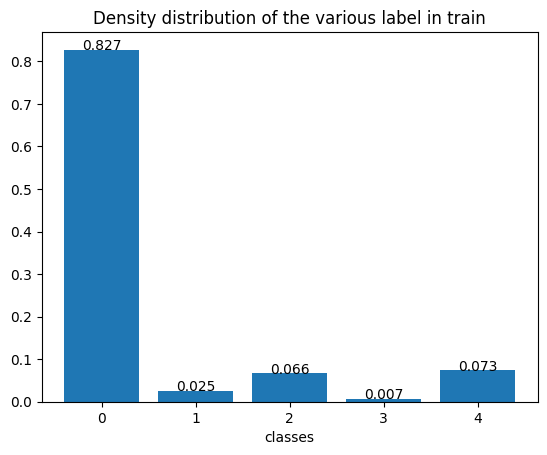

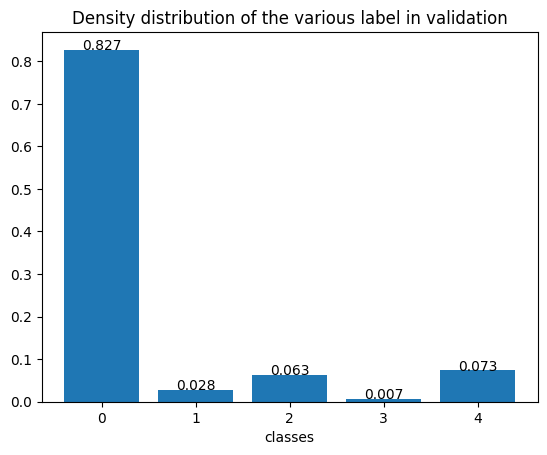

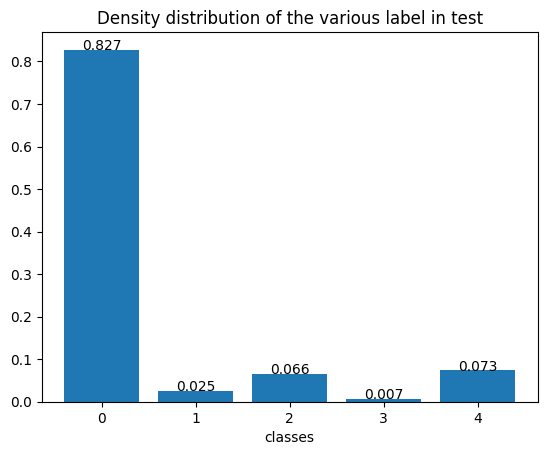

In [5]:
## For simplicity I take the indexes from the dataset of the first element with a specific label
def plot_distribution_dataset(ds: pd, key:str):
    density = [ds[ds[ds.columns[-1]] == i].shape[0]/ds.shape[0] for i in ds[ds.columns[-1]].unique()]

    # Given a visual representation of the density of the label distribution 
    fig, ax = plt.subplots()    
    plt.bar(range(len(density)), density)
    plt.xlabel('classes')
    plt.title(f'Density distribution of the various label in {key}')
    for i, v in enumerate(density):
        ax.text(i, v, str(v)[:5], ha = "center")
    plt.show()

for key in ['train','validation', 'test']:
    plot_distribution_dataset(dataset[key], key)

In [6]:
np.random.seed(1234)

def balance(ds: pd):
    n_obs = np.inf
    for i in list(ds[ds.columns[-1]].unique()):
        n_obs = min(n_obs, ds[ds[ds.columns[-1]] == i].shape[0])
    out = pd.DataFrame()
    for i in list(ds[ds.columns[-1]].unique()):
        tmp = ds[ds[ds.columns[-1]] == i].reset_index(drop = True)
        index = random.sample(range(len(tmp)), n_obs)
        tmp = tmp.iloc[index, :]
        out = pd.concat([out,tmp], ignore_index=True,axis=0)
    return out.reset_index(drop = True)

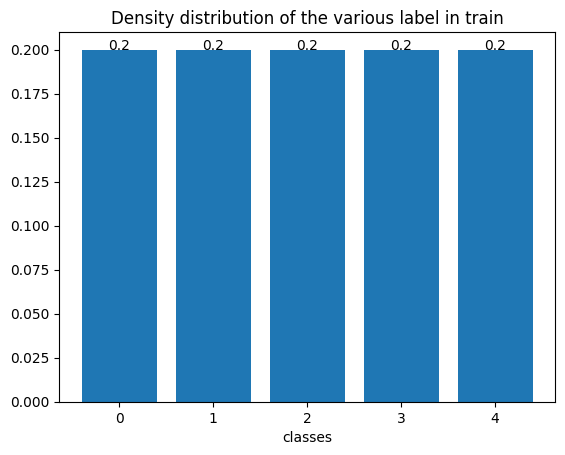

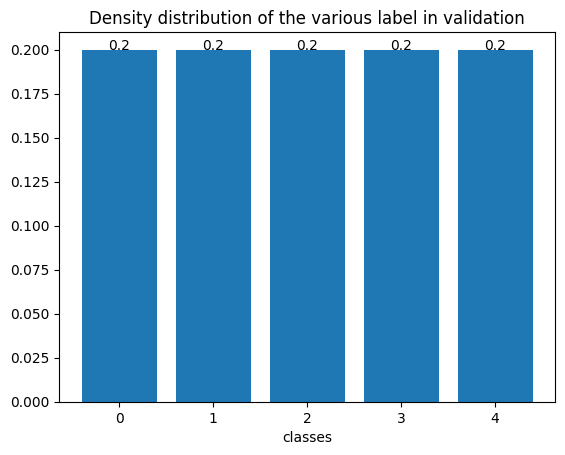

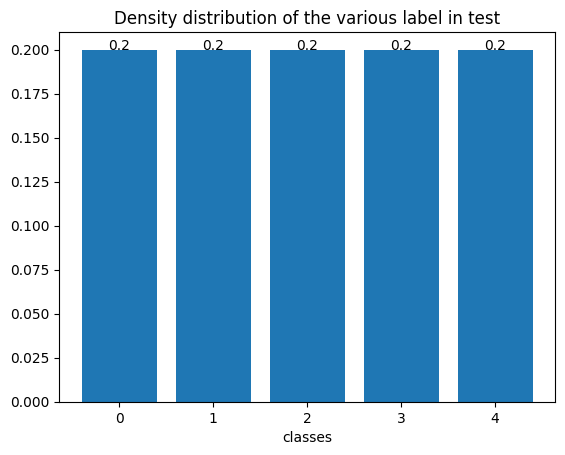

In [7]:
ds = {}
for key in ['train','validation', 'test']:
    ds[key] = balance(dataset[key])
    plot_distribution_dataset(ds[key], key)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


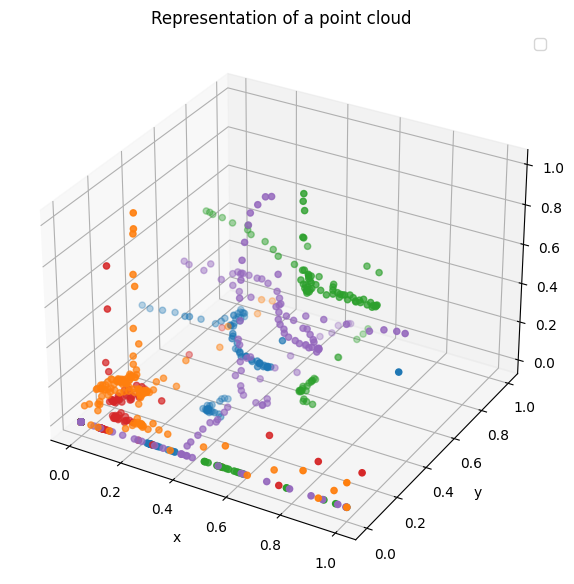

In [8]:
embedding_dimension_periodic = 3
embedding_time_delay_periodic = 25
stride = 1

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=os.cpu_count(),
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

fig = plt.figure(figsize=(7,15))
ax = plt.axes(projection = '3d')
indexes = [ds["train"][ds["train"][ds["train"].columns[-1]] == i].index.min() for i in ds["train"][ds["train"].columns[-1]].unique()]

for i in indexes:
    y_periodic_embedded = embedder_periodic.fit_transform(ds['train'].values[i,:-1])
    ax.scatter3D(y_periodic_embedded[:,0],y_periodic_embedded[:,1], y_periodic_embedded[:,2]);
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_title('Representation of a point cloud');
plt.show()

In [9]:
import multiprocessing
from multiprocessing import Process
max_dimension = config.getint('homology','max_dimension')

cp = {}
label = {}
for key in ['train','validation','test']:
    if os.path.exists(os.path.join(config['paths']['dataset'], f"cloud_points_{key}.pkl")):
        with open(os.path.join(config['paths']['dataset'], f"cloud_points_{key}.pkl"), "rb") as f:
            tmp_cp = pickle.load(f)
        with open(os.path.join(config['paths']['dataset'], f"target_label_{key}.pkl"), "rb") as f:
            tmp_tl = pickle.load(f)   
        cp[key] = tmp_cp
        label[key] = tmp_tl
    else:
        cp[key], label[key] = get_cloud_point(config = config,
                                              key = key,
                                              ds = ds[key])
        

In [10]:
def get_feat(cp,
            vr_simplexes:bool,
            max_dimension:int):
    
    inf = 0.6
    if vr_simplexes:
        distance = cdist(cp,cp)
        complexes = RipsComplex(distance_matrix = distance, max_edge_length = 0.6)
        simplex_tree = complexes.create_simplex_tree(max_dimension = max_dimension)
        
    else:
        np.random.seed(1234)
        land_ind = np.random.choice(range(len(cp)), len(cp)//4, replace = False)
        landmark = cp[land_ind]

        distance = cdist(cp,landmark)
        nearest_landmark_table = [[] for i in range(len(cp))]
        m = 0.0
        for w in range(len(cp)):
            ind_sort = np.argsort(distance[w])
            m = max(m,distance[w,max_dimension+1])
            nearest_landmark_table[w] = [(ind_sort[i], distance[w,ind_sort[i]]**2) for i in range(max_dimension+1)]
    
        complexes = WitnessComplex(nearest_landmark_table = nearest_landmark_table)
        simplex_tree = complexes.create_simplex_tree(max_alpha_square = 0.5,
                                                     limit_dimension = max_dimension)
        
        inf = m
        
    simplex_tree.compute_persistence()
    simplexes = simplex_tree.persistence()
    bn = simplex_tree.betti_numbers()
    simplexes = np.stack([(*b,a) if b[1] != np.inf else (b[0],inf, a) for a,b in simplexes ])

        
    
    holes = {i: len(simplexes[simplexes[:,2] == i]) for i in range(max_dimension)}
    avg = {}
    sum_lt = {}
    max_lt = {}
    
    for i in range(max_dimension):
        if holes[i]== 0:
            avg[i] = 0
            sum_lt[i] = 0
            max_lt[i] = 0
        else:
            life = simplexes[simplexes[:, 2]== i][:,1] - simplexes[simplexes[:, 2]== i][:,0]
            avg[i] = np.mean(life)
            sum_lt[i] = np.sum(life)
            max_lt[i] = np.max(life)


    tmp = np.concatenate((list(holes.values()), 
                          list(avg.values()), 
                          list(sum_lt.values()), 
                          list(max_lt.values()), 
                          list(bn)), -1)
    
    return np.array(tmp)

Before the actual GTDA it will be nice to plot the cloud points of the different heart deseses and their persistence diagram. In order to do so, it is necessary to identify a position in the dataset for each deseses

Now it is possible, for each pointcloud, to create the Vietoris-Rips filtration.
The **max_edge_length** parameter is the maximal diameter: only the edges of length less vers this value are included in the one skeleton graph.

In [11]:
def get_plot(cp: dict, 
             indexes: list,
             rips: bool,
             max_dimension: int,
             config: ConfigParser,
             max_alpha_square: float = 0.5,
             show:bool = True):
    fig = plt.figure(figsize = (15,25), constrained_layout=True)
    fig.suptitle('Representation of topological features in the different scenarios')

    subfigs = fig.subfigures(nrows=len(indexes), ncols=1)
    for row, subfig in enumerate(subfigs):
        
        if rips:
            complexes = RipsComplex(points = cp[indexes[row]],
                                       max_edge_length = 0.5)
            simplex_tree = complexes.create_simplex_tree(max_dimension = 3)
        else:

            np.random.seed(1234)
            tmp = cp[indexes[row]]
            land_ind = np.random.choice(range(len(tmp)), len(tmp)//4, replace = False)
            landmark = tmp[land_ind]
            
            distance = cdist(tmp,landmark )
            nearest_landmark_table = [[] for i in range(len(tmp))]
            for w in range(len(tmp)):
                ind_sort = np.argsort(distance[w])
                nearest_landmark_table[w] = [(ind_sort[i], distance[w,ind_sort[i]]**2) for i in range(max_dimension+1)]

            complexes = WitnessComplex(nearest_landmark_table = nearest_landmark_table)
            simplex_tree = complexes.create_simplex_tree()
        
        BarCodes_Rips0 = simplex_tree.persistence()

        subfig.suptitle(f'Persistence plot for {labels[row]}')

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols = 2)
        for i, ax in enumerate(axs):
            if i == 0:
                gd.plot_persistence_diagram(persistence = BarCodes_Rips0, axes = ax)
            else: 
                gd.plot_persistence_barcode(persistence = BarCodes_Rips0, axes = ax)
    
    name = 'pers_diag_VR.png' if rips else 'pers_diag_WC.png'
    plt.savefig(os.path.join(config['paths']['images'], 'pers_diag.png'))
    plt.show(show)

usetex mode requires dvipng.


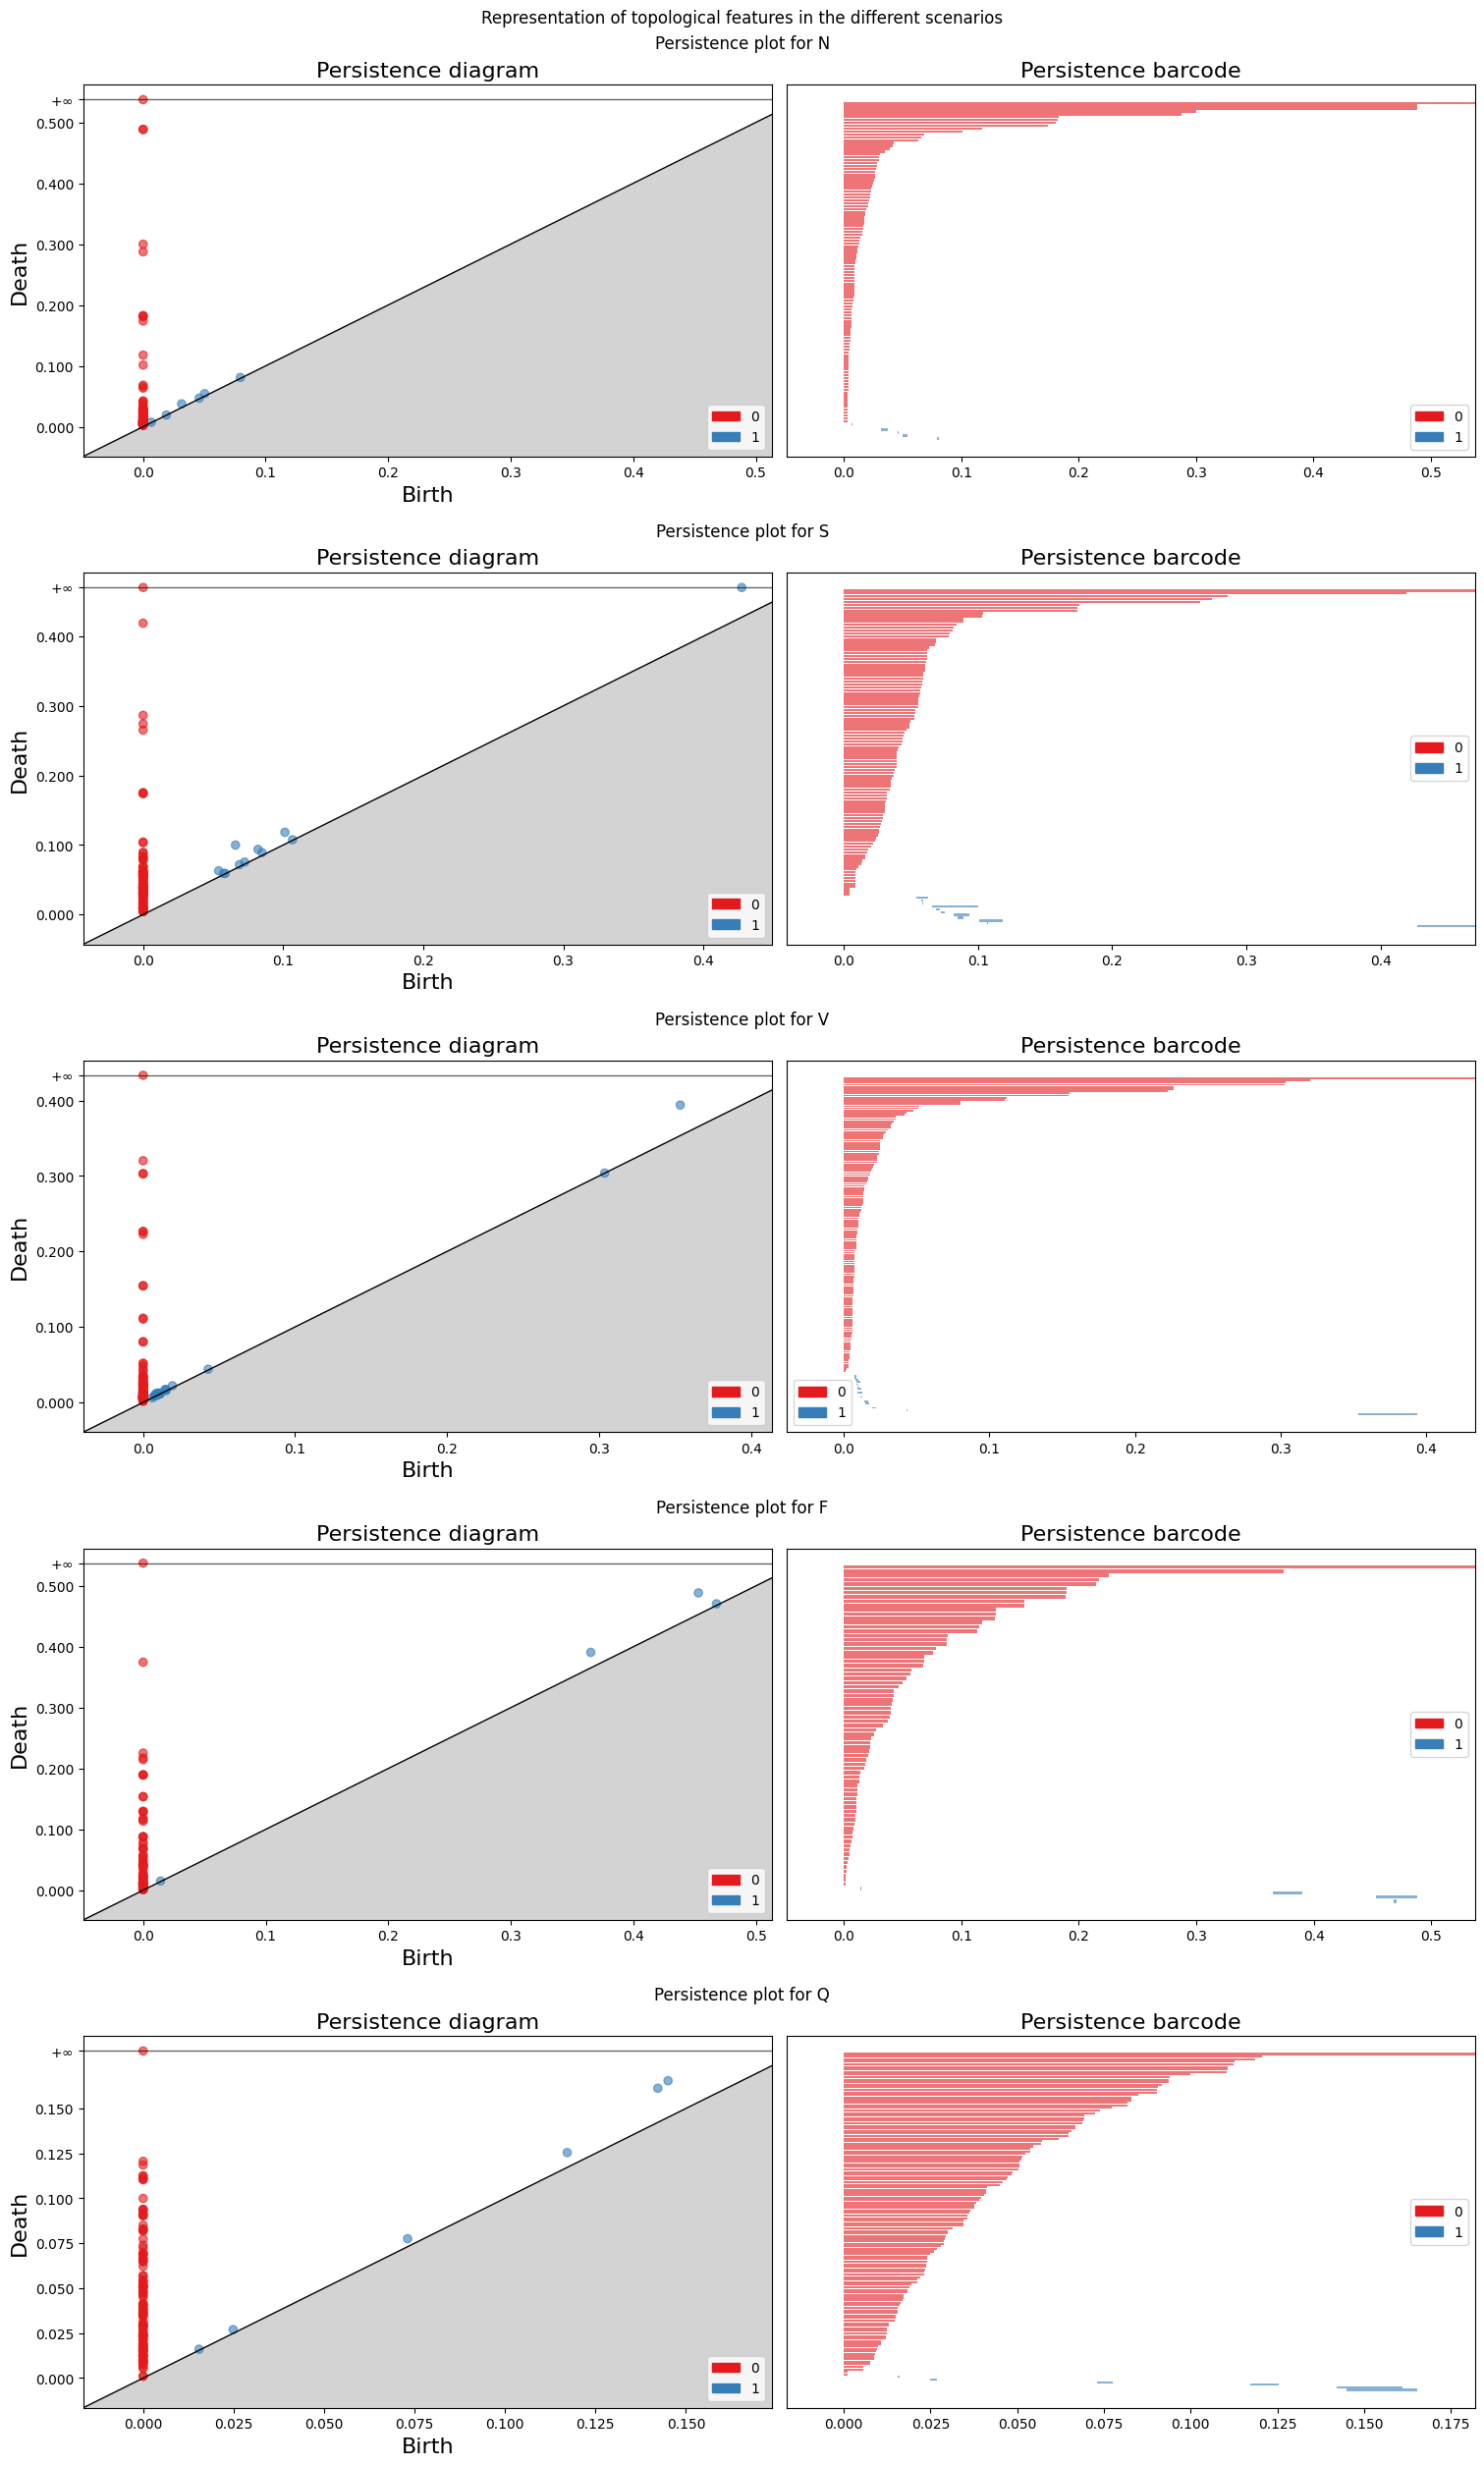

In [12]:
get_plot(cp = cp['train'], 
         indexes = indexes, 
         max_dimension = max_dimension, 
         config = config,
         rips = True)

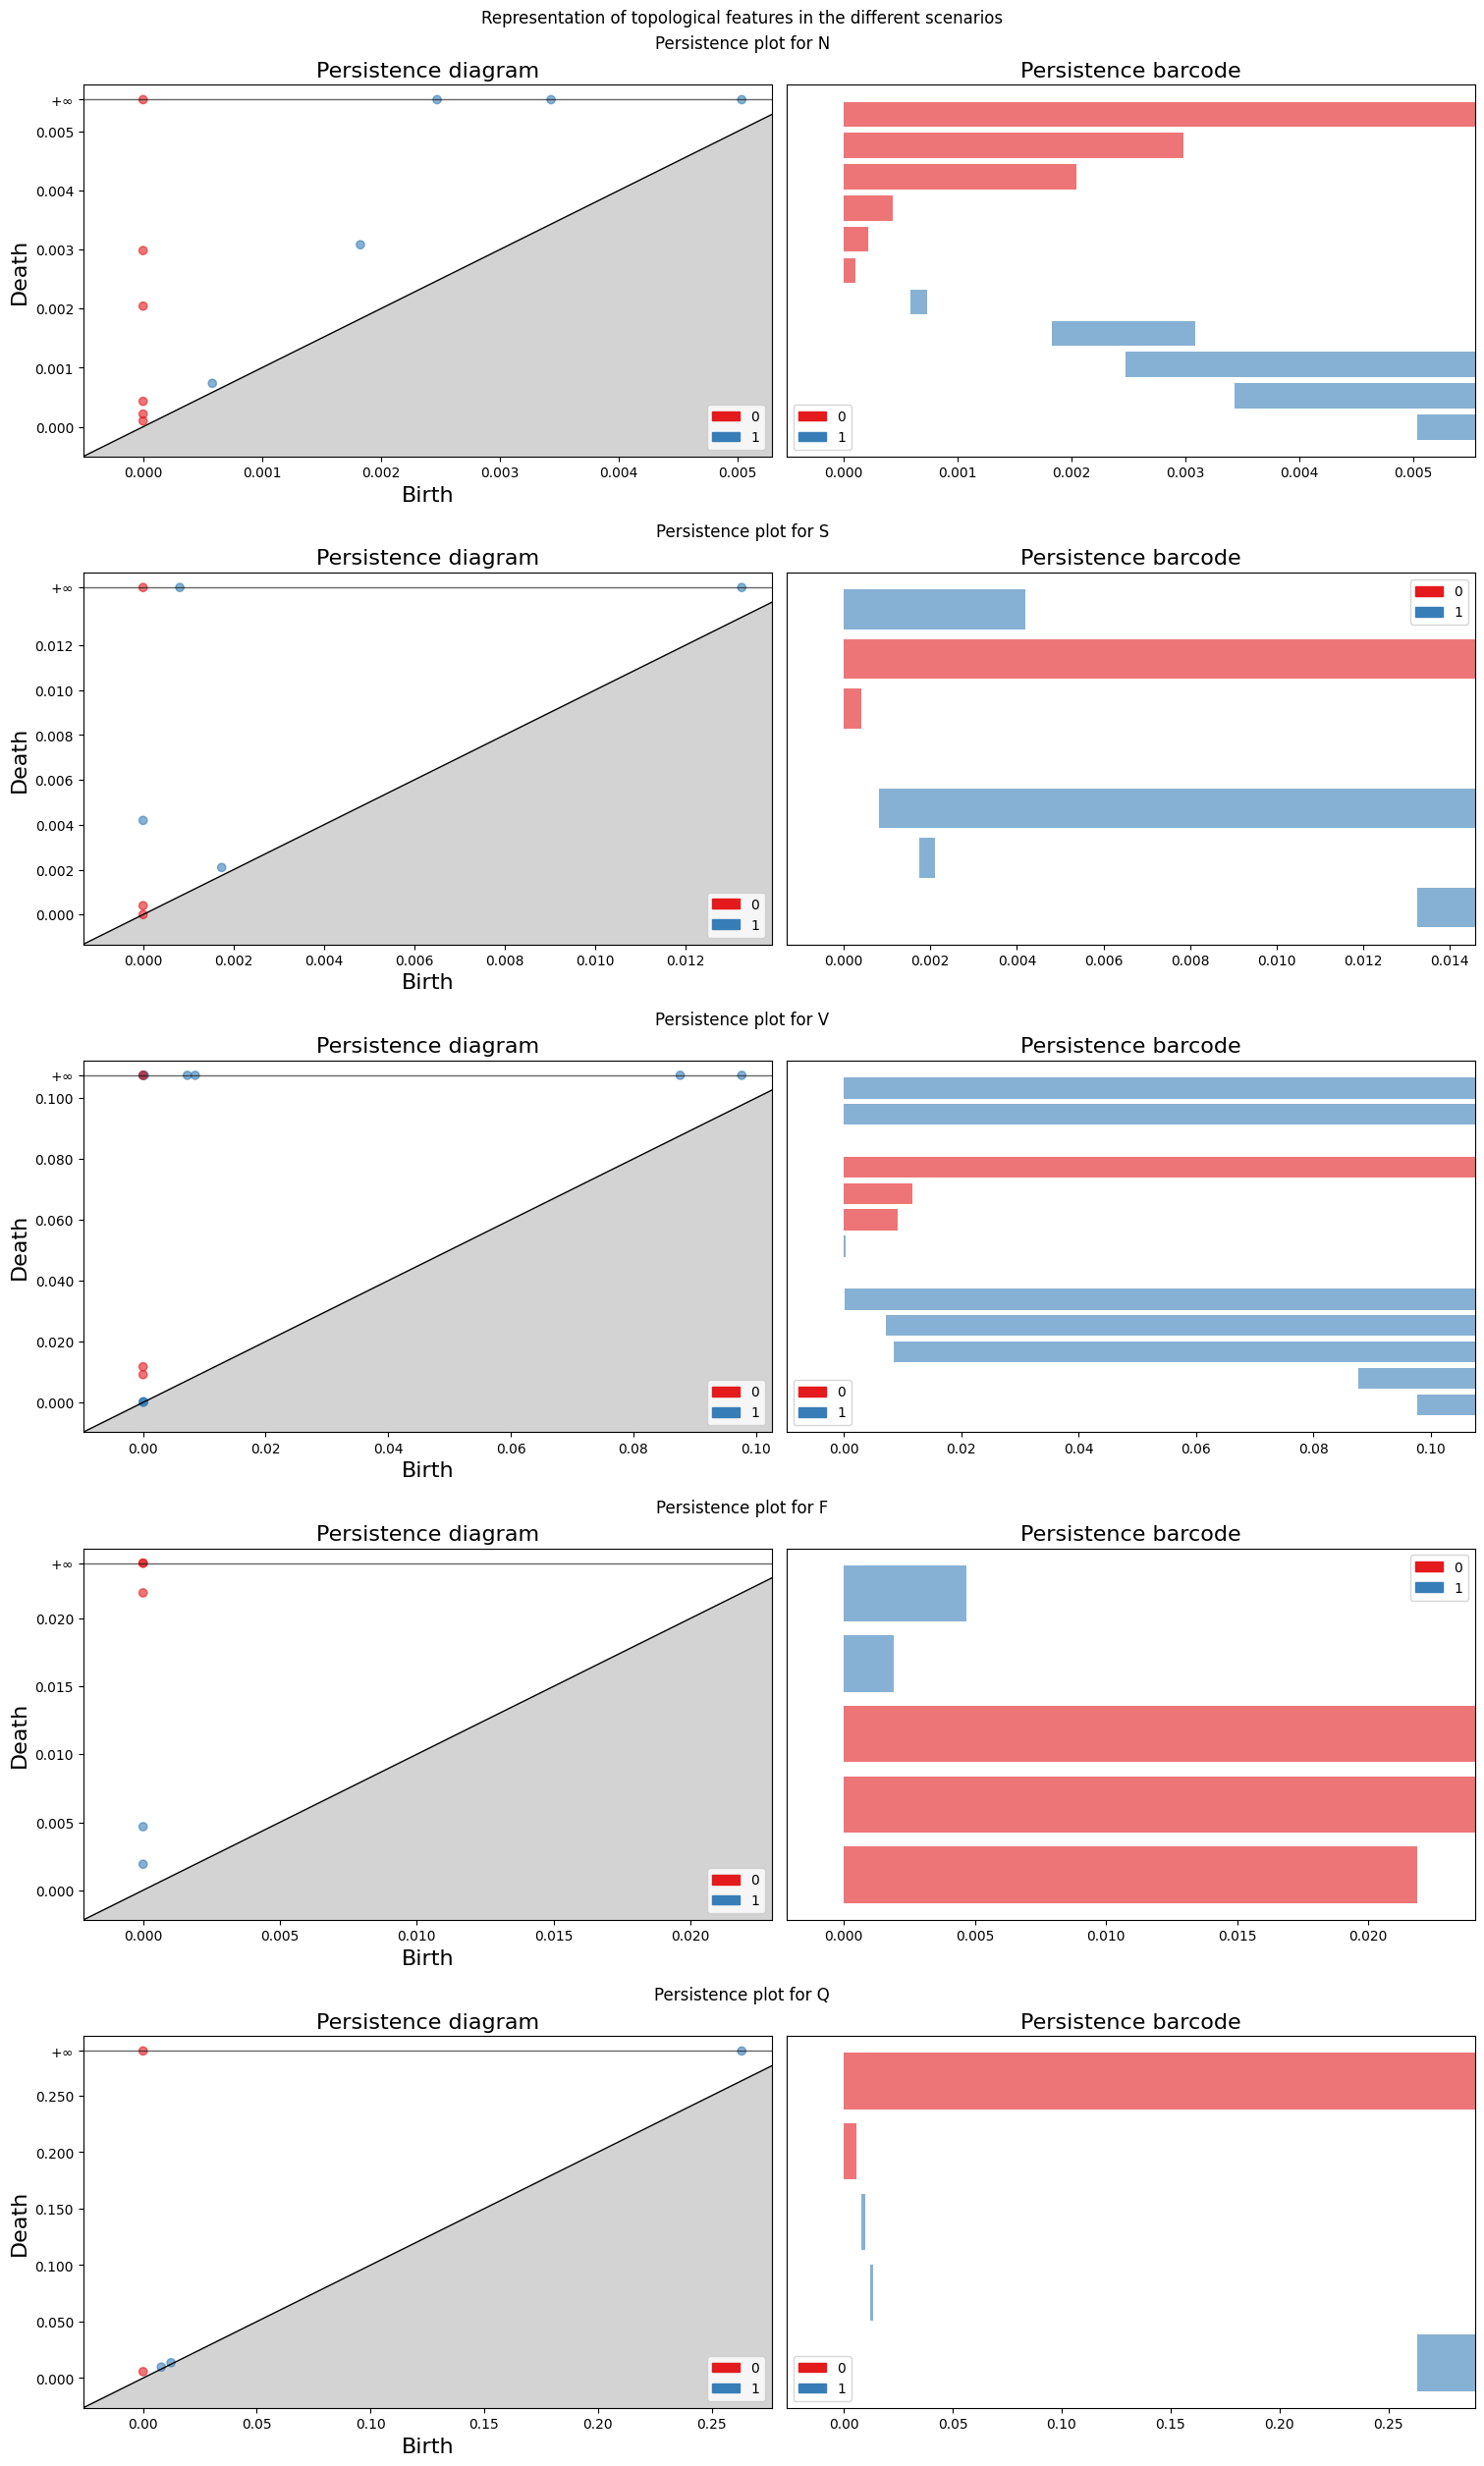

In [13]:
get_plot(cp = cp['train'], 
         indexes = indexes, 
         max_dimension = max_dimension, 
         config = config,
         rips = False)

# DEEP LEARNING 

This part will cover the creation of the supervised dataset and the Deep Learning model.
Since the optimization is based on the reduction of the error of a loss, i.e. the best parametrization $\theta\in \mathbb{R}^m$ of the neural network $\mathcal{N}$ is the one that score the lowest error given a loss
$$
\theta^*:=arg\min_{\theta \in \Theta}\mathcal{L}(\mathcal{N}(\theta),y)
$$
where $y$ is the vector of true value.

In particular this particular case the loss is the Cross Entropy. 
Let $n$ be the number of classes that it is needed to classify. For each classes $i$ it will be given a one-hot-encoding representation, $y \in \{0,1\}^n$, i.e. suppose that $y$ represent the encoding of the $i-th$ clasess then
$$
y_j=\begin{cases}
1& j=i\\
0& j\ne i
\end{cases}
$$
Since the output of the model is a vector $\hat{y}\in[0,1]^n$ then the Loss will be given by
$$
L(\hat{y},y)=-\sum_{j=1}^n\log(\hat{y}_j)y_j
$$

In [14]:
class MyDataset(Dataset):
    def __init__(self, 
                 cp: dict, 
                 label: dict,
                 vr_simplex:bool,
                 max_dimension:int,
                 max_diameter:float):
        self.dataset = []
        self.label = list(label.values())
        
        cps = []
        step = os.cpu_count()
        print("the number of process at the same time is ", step)
        
        with tqdm(total=len(cp)) as progress_bar: 
            for idx in range(0, len(cp), step):
                cps = [cp[j] for j in range(idx, min(idx+step, len(cp)))]
                with Pool(processes=step) as pool:
                    async_result = pool.map(partial(get_feat,
                                                    vr_simplexes = vr_simplex,
                                                    max_dimension = max_dimension), cps)
                    self.dataset.extend(async_result)
                progress_bar.update(step)
                
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idxs):
        return self.dataset[idxs], self.label[idxs]


In [15]:
def get_df(cp:dict,
           config:ConfigParser,
           vr_complexes:bool):
    ds = {}
    for key in ['train','validation','test']:
        name = f'features_VR_{key}.pkl' if vr_complexes else f'features_WD_{key}.pkl'
        if os.path.exists(os.path.join(config['paths']['dataset'], name)):
            with open(os.path.join(config['paths']['dataset'], name), "rb") as f:
                ds[key] = pickle.load(f)
        else:
            tmp = MyDataset(cp = cp[key], 
                            label = label[key], 
                            vr_simplex = True,
                            max_dimension = max_dimension, 
                            max_diameter = max_dimension)
            ds[key] = tmp
            with open(os.path.join(config['paths']['dataset'], name), "wb") as f:
                pickle.dump(tmp, f)
    return ds

In [16]:
class classifier(torch.nn.Module):
    def __init__(self, 
                 nfeat_in: int,
                 nclass: int,
                 hidden_size: int = 128, 
                 temperature:float = 1):
        
        super(classifier, self).__init__()
        self.T = temperature
        self.linear = nn.Sequential(nn.BatchNorm1d(nfeat_in),
                                    nn.Linear(in_features = nfeat_in, 
                                              out_features = hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(in_features = hidden_size, 
                                              out_features = hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(in_features = hidden_size, 
                                              out_features = hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(in_features = hidden_size,
                                              out_features = hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(in_features = hidden_size,
                                              out_features = nclass),
        )
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x):   
        x = self.linear(x.float())
        x = self.softmax(x/self.T)
        return x


In [17]:
def training(model,
             optimizer, 
             loss_function,
             dl_train: DataLoader, 
             dl_validation: DataLoader,
             config: ConfigParser, 
             epochs: int, 
             ds: int
             ):
    prec_train = []
    prec_val = []
    loss_train = []
    loss_val = []
    be = 0.0
    
    if ds == 0:
        name = 'WD'  
    elif ds == 1: 
        name = 'VR' 
    elif ds == 2:
        name = 'finale'
        
    for epoch in tqdm(range(epochs)):
        
        ##### stores the number of right guesses that the model does this epoch ####
        p_train = 0.0
        p_val = 0.0
        
        ##### stores the amount of elements that are seen in each DataLoader ####
        total_train = 0
        total_val = 0
        
        ##### stores the total loss of the epoch ####
        lt = 0.0
        lv = 0.0
        
        ######### Training part ##########
        model.train()
        for i, batch in enumerate(dl_train):
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            lt += loss.item()
            total_train += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            p_train += (predicted == labels).sum().item()
        
        ######### Saving the results of the training for this epoch ########
        prec_train.append(p_train/total_train)
        loss_train.append(lt/len(dl_train))
        
        ######### Evaluation part ##########
        model.eval()
        for i, batch in enumerate(dl_validation):
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            lv += loss.item()
            total_val += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            p_val += (predicted == labels).sum().item()


        ######### Saving the results of the evaluation for this epoch ########
        prec_val.append(p_val/total_val)        
        loss_val.append(lv/len(dl_validation))
        
        if prec_val[-1]>= be:
            be = prec_val[-1]
            torch.save(model.state_dict(), os.path.join(config['paths']['net_weights_train'], f'bm_{name}.pt'))
    return loss_train, loss_val, prec_train, prec_val

In [18]:
def get_plot_performance(loss_train: list, 
                         loss_val: list, 
                         prec_train: list, 
                         prec_val: list, 
                         ds: int):
    fig, ax = plt.subplots(2, figsize=(10, 5), constrained_layout = True)
    if ds == 0:
        name = 'WD'  
    elif ds == 1: 
        name = 'VR' 
    elif ds == 2:
        name = 'both'
        
    fig.suptitle(f'performance of the model with {name} complexes')

    ax[0].plot(prec_train, label = "train")
    ax[0].plot(prec_val, label = "validation")
    ax[0].set_title("Precision")
    ax[0].legend()


    ax[1].plot(loss_train, label = "train")
    ax[1].plot(loss_val, label = "validation")
    ax[1].set_title("loss")
    ax[1].legend()
    plt.show()

def get_heat_map(model, dl):
    d = {i:[0]*5 for i in range(5)}
    p_train = 0.0
    total = 0

    model.eval()
    for i, batch in enumerate(dl):
        inputs = batch[0].to(model.device)
        labels = batch[1].to(model.device).long()

        outputs = model(inputs)

        total += labels.size(0)
        _, predicted = torch.max(outputs, 1)

        for lab in range(5):
            # I take all the elements 
            tmp = predicted[labels == lab]
            for i in range(5):
                d[lab][i] += len(tmp[tmp == i])
    n = {}        
    for lab in range(5):
        tot = np.sum(d[lab])
        n[lab] = tot
        for i in range(5):
            d[lab][i] = d[lab][i]/tot
            
    return d
def get_plot_confusion(model, dl_train, dl_validation):
    
    ###### Markov matrix #####
    ###### known that the true value is the index of the row 
    ###### which is the probability to say the index on the column
    ###### the diagonal is equivalent to the proability of the correct result
    
    d_train = get_heat_map(model, dl_train)
    d_val = get_heat_map(model, dl_validation)
    
    df1 = pd.DataFrame(d_train.values())
    df2 = pd.DataFrame(d_val.values())
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout = True)
    ax1, ax2 = axes

    im1 = ax1.matshow(df1)
    im2 = ax2.matshow(df2)

    fig.colorbar(im1, ax = ax1)
    fig.colorbar(im2, ax = ax2)
    
    for (x, y), value in np.ndenumerate(df1):
        col = 'white' if x != y else 'black'
        ax1.text(y, x, f"{value:.2f}", color = col, va="center", ha="center")
        
    for (x, y), value in np.ndenumerate(df2):
        col = 'white' if x != y else 'black'
        ax2.text(y, x, f"{value:.2f}", color = col, va="center", ha="center")
    
    ax1.set_title('Train')
    ax2.set_title('Validation')
    
    fig.suptitle('Heatmap for the confusion matrix')
    plt.show()
    
    return df1, df2

## Witness complexes

In [34]:
ds_wc = get_df(cp = cp, config=config, vr_complexes=False)

batch_size = 1024#config.getint('dataset','batch_size')
dl_WC = {}
for key in ds.keys():
    dl_WC[key] = DataLoader(ds_wc[key], 
                             shuffle = True, 
                             batch_size = batch_size)
batch = next(iter(dl_WC['train']))

In [35]:
model = classifier(nfeat_in = batch[0].shape[1], 
                   nclass = 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.device = device

# 4. Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),                       
                       lr = 1e-4, 
                       weight_decay = 5e-4)

In [36]:
loss_train, loss_val, prec_train, prec_val = training(model = model, 
                                                      optimizer = optimizer, 
                                                      loss_function = loss_function,
                                                      config = config, 
                                                      dl_train = dl_WC['train'], 
                                                      dl_validation = dl_WC['validation'], 
                                                      epochs = 400, 
                                                      ds = 0)

100%|█████████████████████████████████████████| 400/400 [00:09<00:00, 42.61it/s]


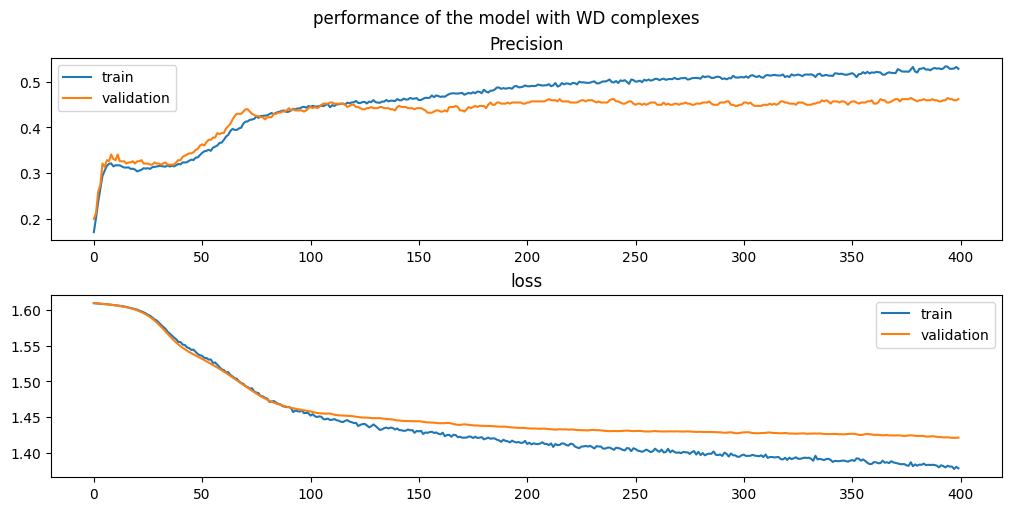

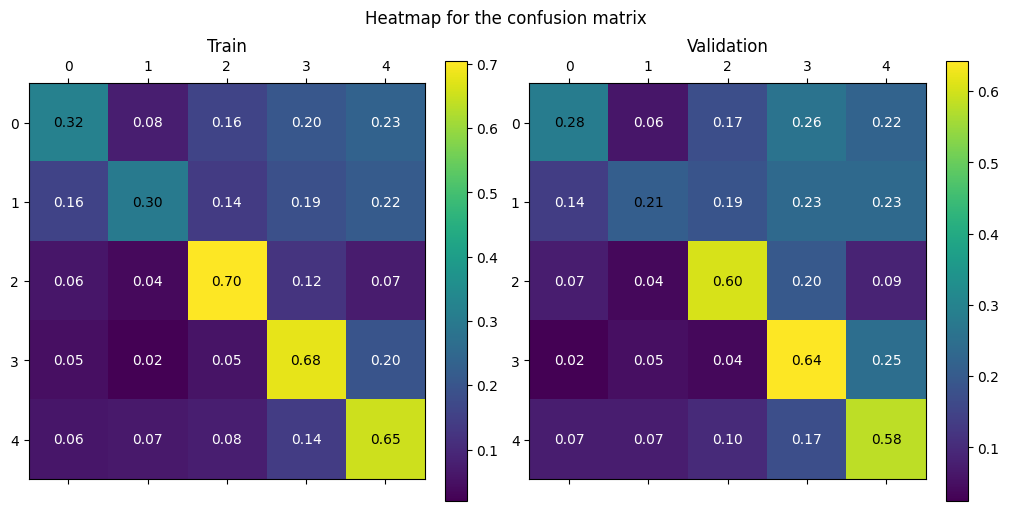

In [37]:
get_plot_performance(loss_train, 
                     loss_val, 
                     prec_train, 
                     prec_val, 
                     ds = 0)
model.load_state_dict(torch.load(os.path.join(config['paths']['net_weights_train'], 'bm_WD.pt')))
df1_wc, df2_wc = get_plot_confusion(model = model, 
                                   dl_train = dl_WC['train'], 
                                   dl_validation = dl_WC['validation'])

## Vietoris-Rips complexes

In [38]:
ds_vr = get_df(cp = cp, config=config, vr_complexes=True)

dl_VR = {}
for key in ds.keys():
    dl_VR[key] = DataLoader(ds_vr[key], 
                         shuffle = True, 
                         batch_size = batch_size)
batch = next(iter(dl_VR['train']))

In [39]:
model = classifier(nfeat_in = batch[0].shape[1], 
                   nclass = 5, 
                   temperature = 0.01)
model.to(device)
model.device = device
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-4, 
                       weight_decay = 5e-4)

In [40]:
loss_train, loss_val, prec_train, prec_val = training(model = model, 
                                                      optimizer = optimizer, 
                                                      loss_function = loss_function,
                                                      config = config, 
                                                      dl_train = dl_VR['train'], 
                                                      dl_validation = dl_VR['validation'], 
                                                      epochs = 250, 
                                                      ds = 1)

100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 43.59it/s]


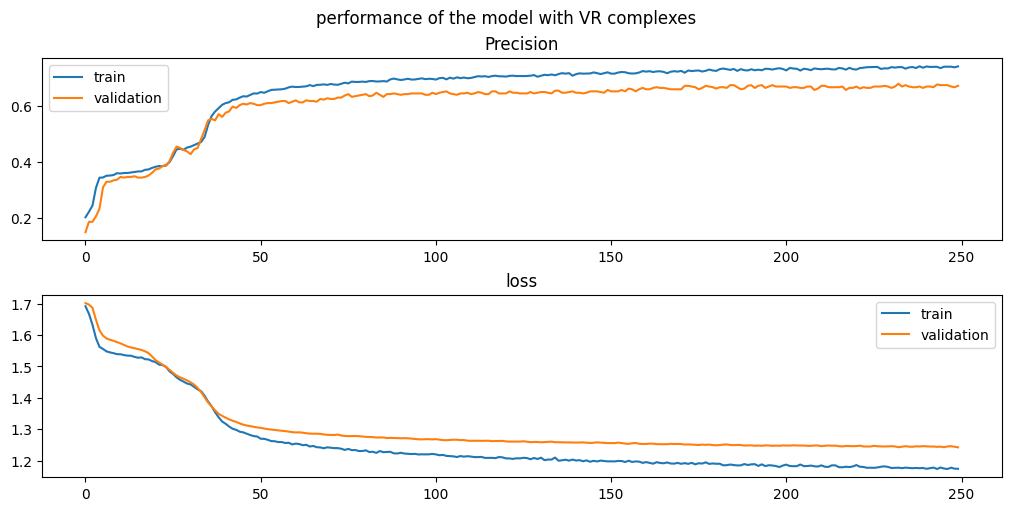

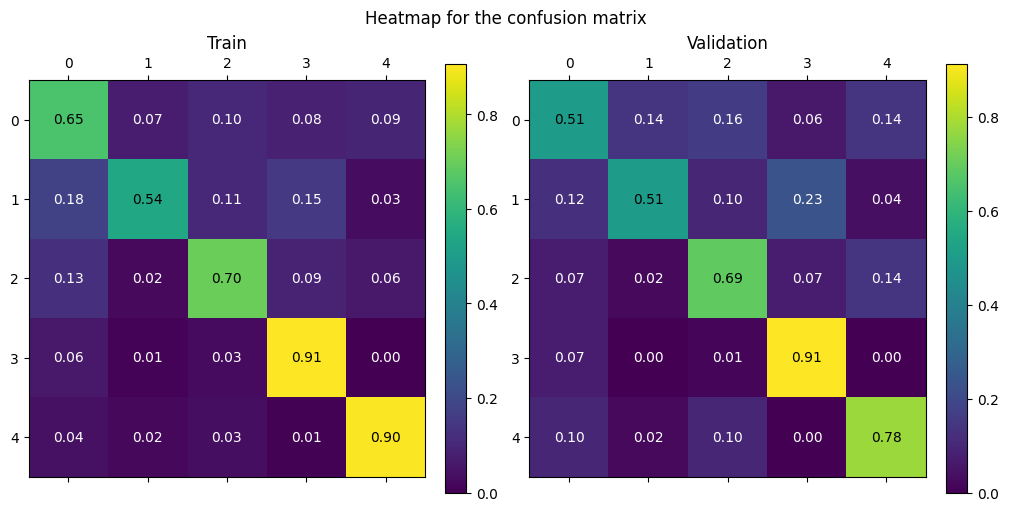

In [41]:
get_plot_performance(loss_train, loss_val, prec_train, prec_val, 1)
model.load_state_dict(torch.load(os.path.join(config['paths']['net_weights_train'], 'bm_VR.pt')))
df1_vr, df2_vr= get_plot_confusion(model = model, 
                                  dl_train = dl_VR['train'], 
                                  dl_validation = dl_VR['validation'])

## Union of the two complexes

In [46]:
dl_finale = {}
for key in ds_wc.keys():
    tmp_ds =  np.concatenate((ds_wc[key].dataset, ds_vr[key].dataset), -1)
    tmp_ds = TensorDataset(torch.tensor(tmp_ds), torch.tensor(ds_wc[key].label))
    dl_finale[key] = DataLoader(tmp_ds, 
                                batch_size = batch_size, 
                                shuffle = True)
batch = next(iter(dl_finale['train']))

In [51]:
model = classifier(nfeat_in = batch[0].shape[1], 
                   nclass = 5,
                   hidden_size=256,
                   temperature=0.01)
model.to(device)
model.device = device
optimizer = optim.Adam(model.parameters(), 
                       lr = 5e-4, 
                       weight_decay = 5e-4)

In [52]:
loss_train, loss_val, prec_train, prec_val = training(model = model, 
                                                      optimizer = optimizer, 
                                                      loss_function = loss_function,
                                                      config = config, 
                                                      dl_train = dl_finale['train'], 
                                                      dl_validation = dl_finale['validation'], 
                                                      epochs = 250, 
                                                      ds = 2)

100%|█████████████████████████████████████████| 250/250 [00:10<00:00, 24.19it/s]


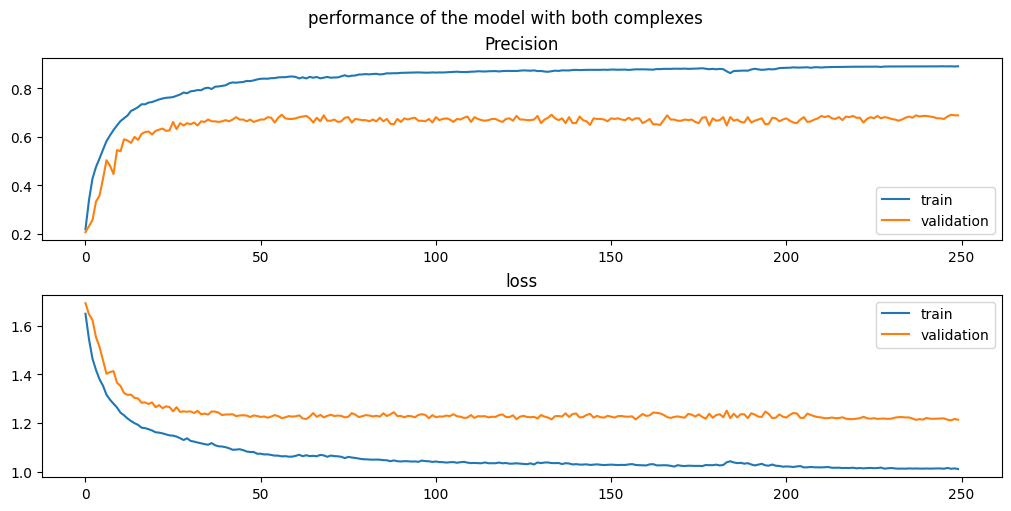

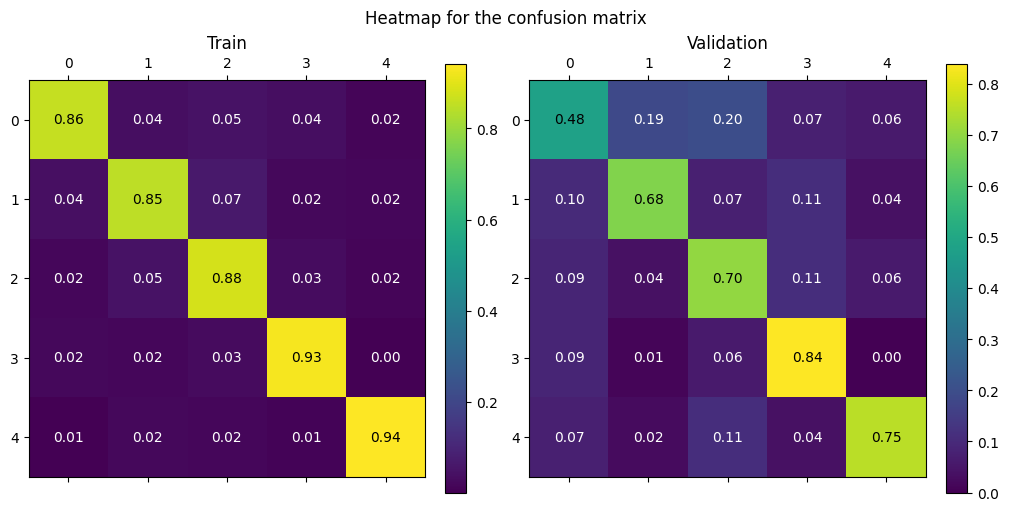

In [53]:
get_plot_performance(loss_train, loss_val, prec_train, prec_val, 2)
model.load_state_dict(torch.load(os.path.join(config['paths']['net_weights_train'], 'bm_finale.pt')))
df1_f,df2_f = get_plot_confusion(model = model, 
                                 dl_train = dl_finale['train'], 
                                 dl_validation = dl_finale['validation'])

# Reliability 
from the performance the true values that we wanna know is the probability that the predicted value is the right value, i.e. let $T\sim Be(0.20)$ be the r.v. that tells which classes it is taken in consideration and $M\sim Be(\underline{p})$ the r.v. that represent the prediction of the model then
$$
\mathbb{P}(T=i|M=i)=\frac{\mathbb{P}(M=i|T=i)\mathbb{P}(T=i)}{\mathbb{P}(M=i)}=\frac{\mathbb{P}(M=i|T=i)}{\sum_{j=0}^4\mathbb{P}(M=i|T=j)}
$$

### Train

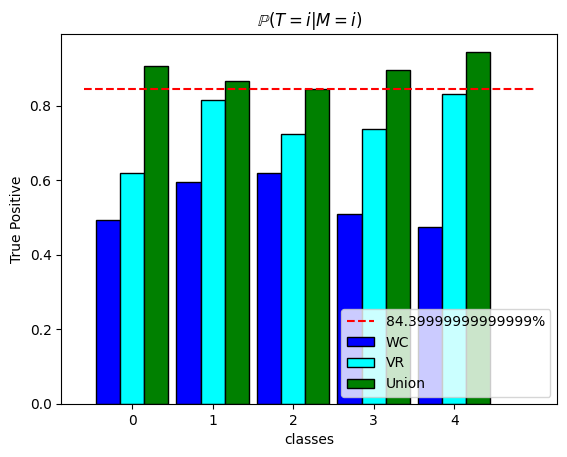

In [54]:
p = df1_wc.to_numpy()
wc = np.diag(p)/np.sum(p,0)

p = df1_vr.to_numpy()
vr = np.diag(p)/np.sum(p,0)

p = df1_f.to_numpy()
f = np.diag(p)/np.sum(p,0)


#width of the bars
barWidth = 0.3

r1 = np.arange(len(wc))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
 

plt.bar(r1, list(wc), width = barWidth, color = 'blue', edgecolor = 'black', label = "WC")
plt.bar(r2, vr, width = barWidth, color = 'cyan', edgecolor = 'black', label = "VR")
plt.bar(r3, f, width = barWidth, color = 'green', edgecolor = 'black', label = "Union")
 
# general layout
plt.plot(np.linspace(-barWidth,len(wc)+barWidth, 100),[round(min(f),3)]*100, '--', color = 'red', label = f"{round(min(f),3)*100}%")
plt.xticks([r + barWidth for r in range(len(wc))], range(5))
plt.ylabel('True Positive')
plt.xlabel('classes')
plt.title("$\mathbb{P}(T=i|M=i)$")
plt.legend()
# Show graphic
plt.show()

### Validation 

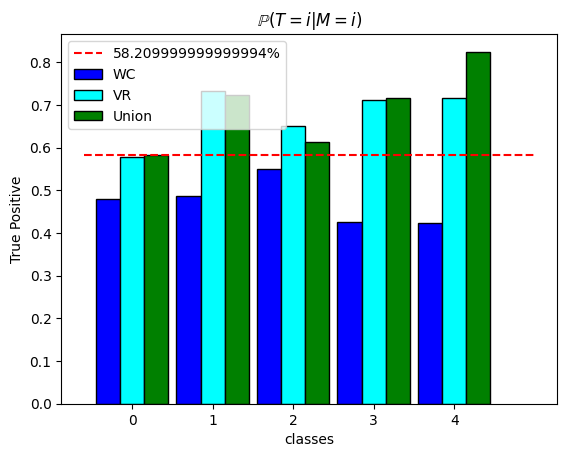

In [55]:
p = df2_wc.to_numpy()
wc = np.diag(p)/np.sum(p,0)

p = df2_vr.to_numpy()
vr = np.diag(p)/np.sum(p,0)

p = df2_f.to_numpy()
f = np.diag(p)/np.sum(p,0)


#width of the bars
barWidth = 0.3

r1 = np.arange(len(wc))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
 

plt.bar(r1, list(wc), width = barWidth, color = 'blue', edgecolor = 'black', label = "WC")
plt.bar(r2, vr, width = barWidth, color = 'cyan', edgecolor = 'black', label = "VR")
plt.bar(r3, f, width = barWidth, color = 'green', edgecolor = 'black', label = "Union")
 
# general layout
plt.plot(np.linspace(-barWidth,len(wc)+barWidth, 100),[min(f)]*100, '--', color = 'red', label = f"{round(min(f),4)*100}%")
plt.xticks([r + barWidth for r in range(len(wc))], range(5))
plt.ylabel('True Positive')
plt.xlabel('classes')
plt.title("$\mathbb{P}(T=i|M=i)$")
plt.legend()
# Show graphic
plt.show()